In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import Normal 
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima_process import ArmaProcess # To generate sample data

In [3]:
stoxx500 = pd.read_csv('data/QRM-2025-cw1-data-a(1).csv')
stoxx500.head()

,Date,Adj Close
0,30/10/2013,3040.689941
1,31/10/2013,3067.949951
2,01/11/2013,3052.139893
3,04/11/2013,3061.179932
4,05/11/2013,3035.919922


In [4]:
stoxx500['log_return'] = (np.log(stoxx500['Adj Close']) - np.log(stoxx500['Adj Close'].shift(1)))*100 #in percentage

In [5]:
lr_features = stoxx500['log_return'].aggregate(['mean', 'skew', 'kurtosis', 'std'])

In [6]:
lr_features

mean         0.011775
skew        -0.795974
kurtosis    10.278073
std          1.239143
Name: log_return, dtype: float64

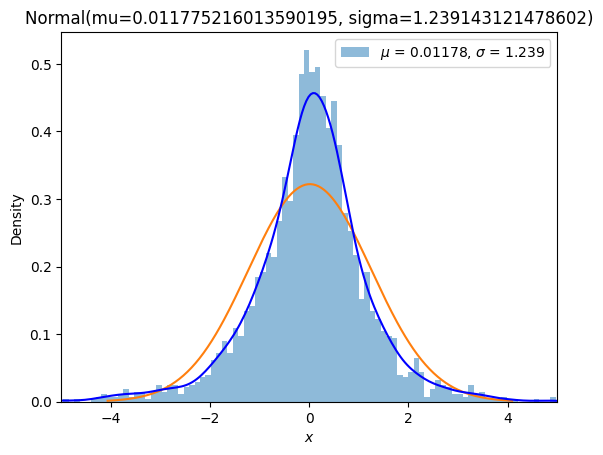

In [7]:
### Normal ditstrib parameterization
mu, skew, kurt, std = lr_features

figure = plt.Figure(figsize=(12,20))
stoxx500['log_return'].plot(kind='hist', density=True, bins = 200, alpha=0.5)
Normal(mu=mu, sigma=std).plot()
stoxx500['log_return'].plot(kind='kde', color='blue')
plt.xlim(-5, 5)
plt.show()

(i) We can conclude that a fitted normal law is not a good approximation for the stock index. Indeed, the index kde has a kurtosis > 3, resulting in thicker tails, and sharper spike.

In [8]:
stoxx500['abs_returns'] = stoxx500['log_return'].apply(abs)
stoxx500['sq_returns'] = stoxx500['log_return'].apply(lambda x: x**2)
stoxx500.head()

,Date,Adj Close,log_return,abs_returns,sq_returns
0,30/10/2013,3040.689941,NaN,NaN,NaN
1,31/10/2013,3067.949951,0.892513,0.892513,0.796579
2,01/11/2013,3052.139893,-0.516662,0.516662,0.266940
3,04/11/2013,3061.179932,0.295749,0.295749,0.087468
4,05/11/2013,3035.919922,-0.828596,0.828596,0.686571


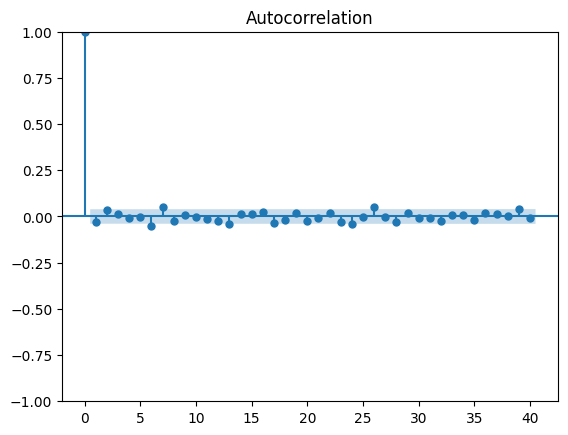

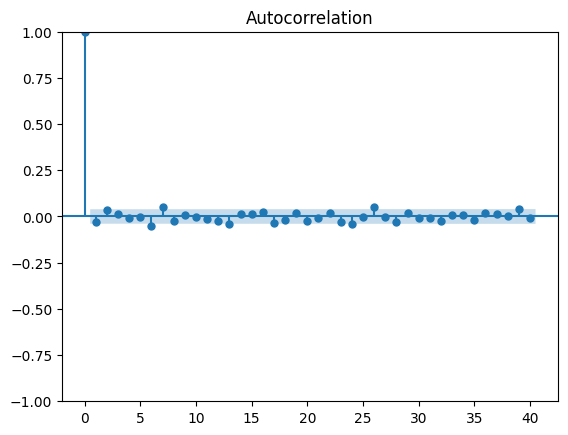

In [9]:
x = stoxx500['log_return'].dropna()
plot_acf(x, lags=40) 

<Axes: >

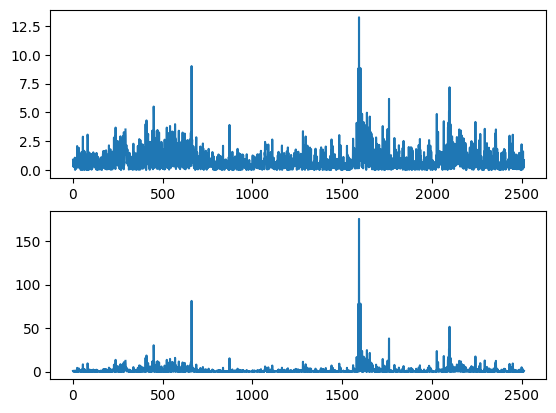

In [10]:
plt.subplot(2, 1, 1)
stoxx500['abs_returns'].plot()
plt.subplot(2, 1, 2)
stoxx500['sq_returns'].plot()


In [11]:
import arch
from arch import arch_model

In [12]:
# Fit standard GARCH(1,1) model with constant conditional mean and standard normal innovations
garch11 = arch_model(x, vol='Garch', p=1, q=1, dist='normal', mean='Constant')
garch11_fit = garch11.fit(disp='off')
print(garch11_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3738.92
Distribution:                  Normal   AIC:                           7485.84
Method:            Maximum Likelihood   BIC:                           7509.14
                                        No. Observations:                 2505
Date:                Tue, Nov 18 2025   Df Residuals:                     2504
Time:                        14:35:53   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0476  2.019e-02      2.360  1.830e-02 [8.

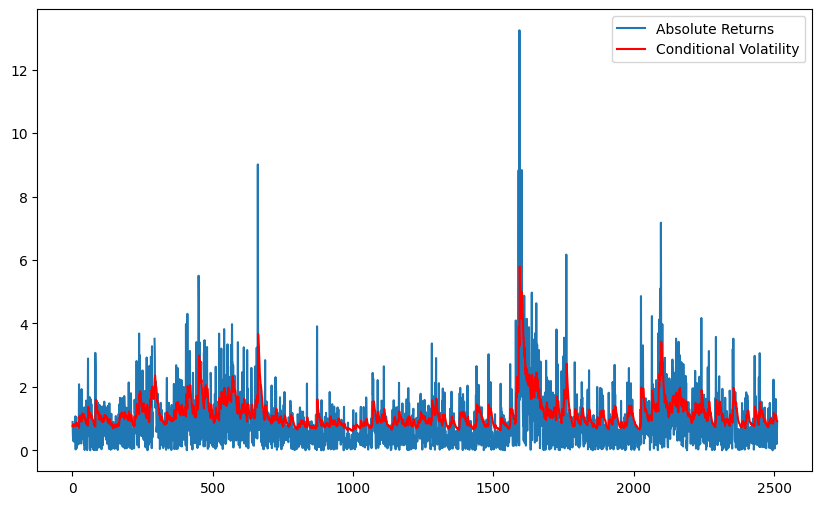

In [13]:
# Plot the absolute returns and the conditional volatility
plt.figure(figsize=(10,6))
plt.plot(stoxx500['abs_returns'], label='Absolute Returns')
plt.plot(garch11_fit.conditional_volatility, label='Conditional Volatility', color='red')
plt.legend()
plt.show()  

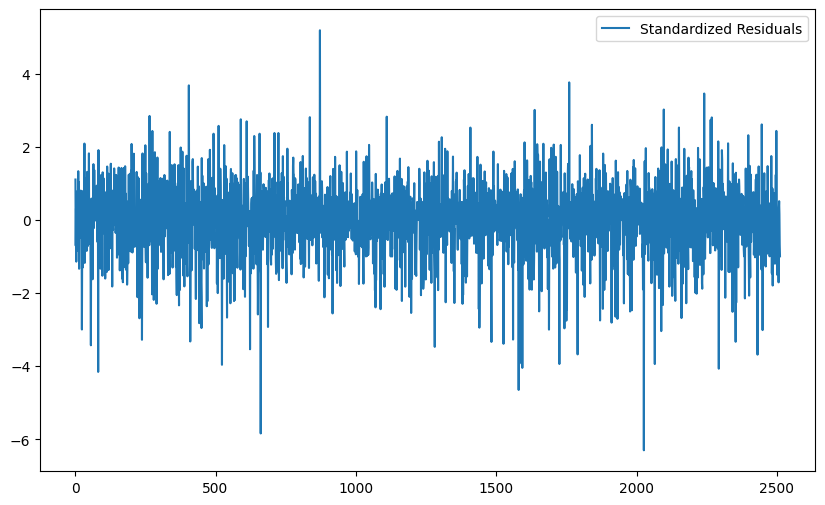

In [14]:
# Print the standardized residuals
standardized_residuals = garch11_fit.std_resid
plt.figure(figsize=(10,6))
plt.plot(standardized_residuals, label='Standardized Residuals')
plt.legend()
plt.show()

                              AR - GARCH Model Results                              
Dep. Variable:                   log_return   R-squared:                      -0.001
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -3636.90
Distribution:      Standardized Student's t   AIC:                           7285.80
Method:                  Maximum Likelihood   BIC:                           7320.75
                                              No. Observations:                 2504
Date:                      Tue, Nov 18 2025   Df Residuals:                     2502
Time:                              14:35:53   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

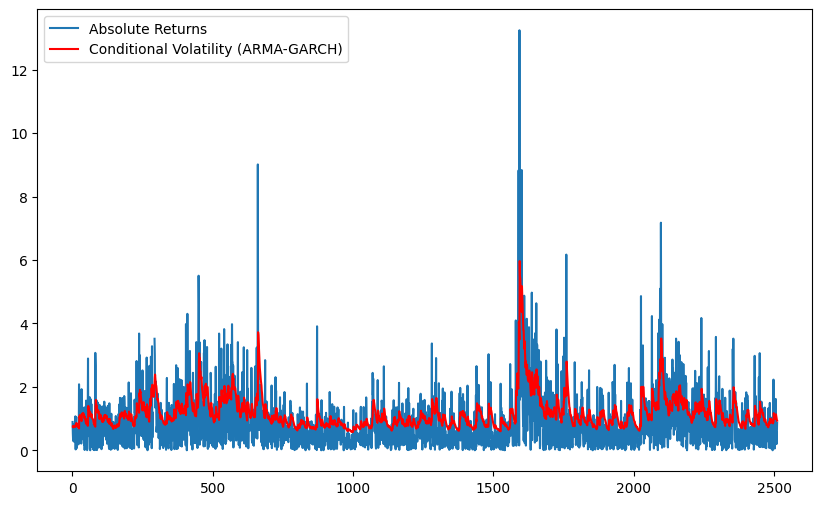

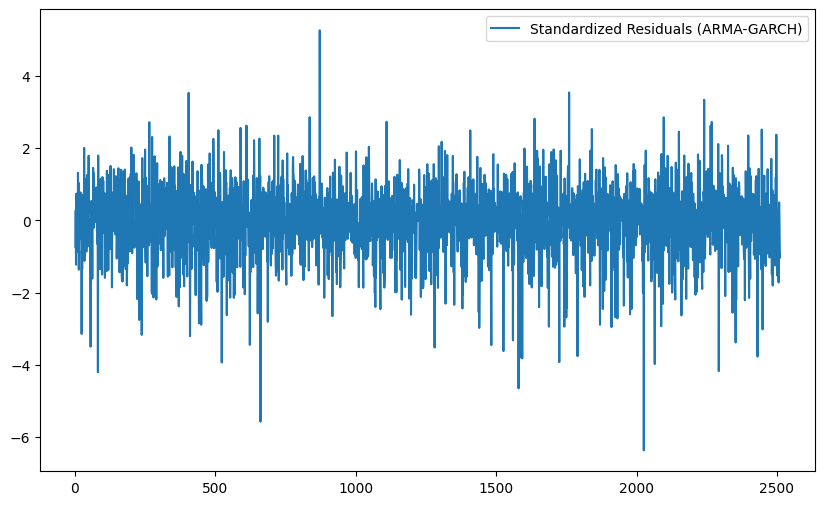

In [15]:
# Fit a ARMA(1,1)-GARCH(1,1) model with t-distributed innovations
arma_garch = arch_model(x, vol='Garch', p=1, q=1, dist='t', mean='ARX', lags=1)
arma_garch_fit = arma_garch.fit(disp='off')
print(arma_garch_fit.summary())
# Plot the asbolute returns and the conditional volatility from the ARMA-GARCH model
plt.figure(figsize=(10,6))
plt.plot(stoxx500['abs_returns'], label='Absolute Returns')
plt.plot(arma_garch_fit.conditional_volatility, label='Conditional Volatility (ARMA-GARCH)', color='red')
plt.legend()
plt.show()
# Print the standardized residuals from the ARMA-GARCH model
arma_standardized_residuals = arma_garch_fit.std_resid
plt.figure(figsize=(10,6))
plt.plot(arma_standardized_residuals, label='Standardized Residuals (ARMA-GARCH)')
plt.legend()
plt.show()  

# Part B

In [17]:
dfB = pd.read_csv('data/QRM-2025-cw1-data-b(1).csv')
dfB.head()

,Date,Adj Close
0,30/10/2013,105.445374
1,31/10/2013,105.823196
2,01/11/2013,105.407578
3,04/11/2013,105.256462
4,05/11/2013,105.407578


# HS

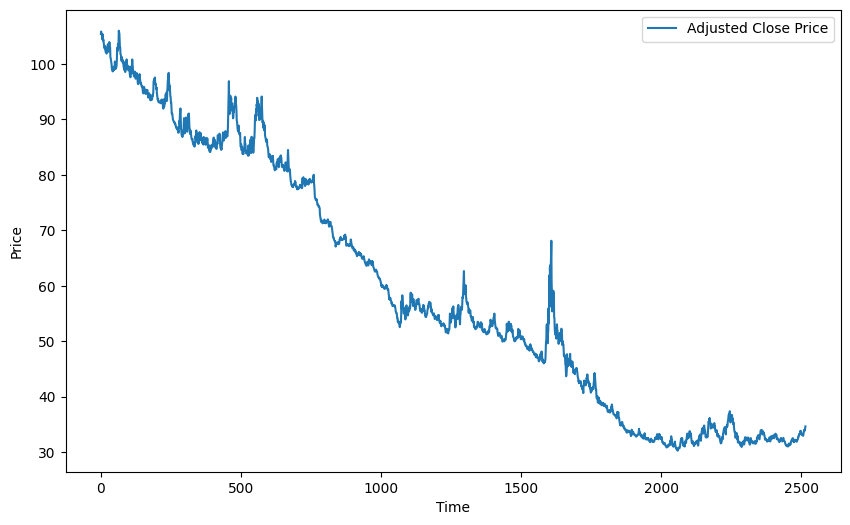

In [21]:
# VaR forecasts 
dfB['log_returns_B'] = np.log(dfB['Adj Close'].dropna()) - np.log(dfB['Adj Close'].dropna().shift(1))
dfB['loss'] = -dfB['log_returns_B']

# Print Adj close
plt.figure(figsize=(10,6))
plt.plot(dfB['Adj Close'], label='Adjusted Close Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [34]:
# VaR Using the past 500 days (Historical Simulation)
window_size = 500
confidence_level = 0.95
var_hs = []
for i in range(window_size, len(dfB)):
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    var = np.percentile(past_losses, confidence_level * 100)
    var_hs.append(var)

confidence_level = 0.99
var_hs_99 = []
for i in range(window_size, len(dfB)):
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    var = np.percentile(past_losses, confidence_level * 100)
    var_hs_99.append(var)  

In [33]:
confidence_level = 0.95
ef_hs_95 = []

for i in range(window_size, len(dfB)):
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    es = past_losses[past_losses >= var_hs[i - window_size]].mean()
    ef_hs_95.append(es)

ef_hs_99 = []
for i in range(window_size, len(dfB)):
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    es = past_losses[past_losses >= var_hs_99[i - window_size]].mean()
    ef_hs_99.append(es)

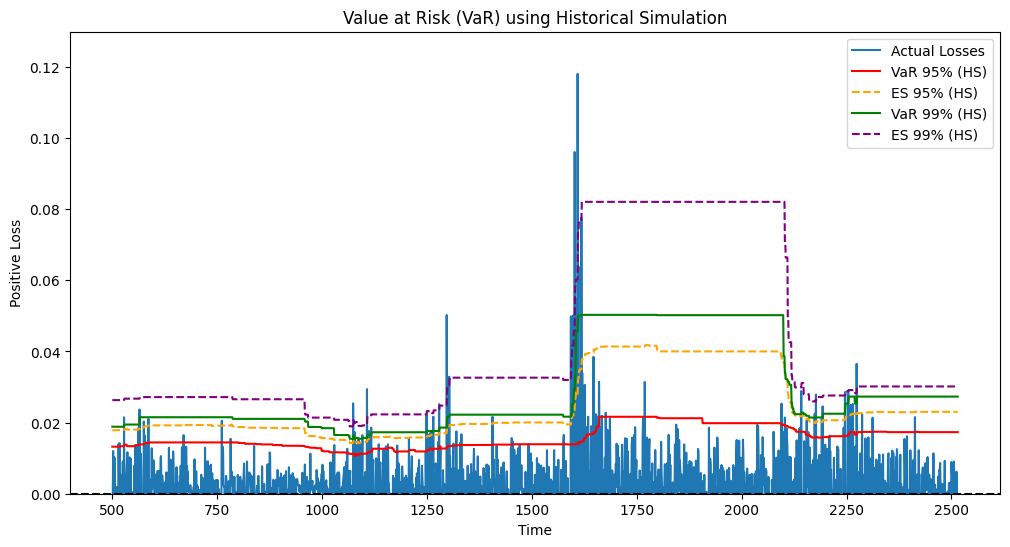

In [35]:
plt.figure(figsize=(12,6))
plt.plot(dfB.index[window_size:], dfB['loss'].iloc[window_size:], label='Actual Losses')
plt.plot(dfB.index[window_size:], var_hs, label='VaR 95% (HS)', color='red')
plt.plot(dfB.index[window_size:], ef_hs_95, label='ES 95% (HS)', color='orange', linestyle='--')
plt.plot(dfB.index[window_size:], var_hs_99, label='VaR 99% (HS)', color='green')
plt.plot(dfB.index[window_size:], ef_hs_99, label='ES 99% (HS)', color='purple', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.title('Value at Risk (VaR) using Historical Simulation')
plt.xlabel('Time')
plt.ylabel('Positive Loss')
plt.ylim(0)
plt.legend()
plt.show()

# FHS

In [43]:
# Calculating the VaR and the Expected Shortfall (ES) at 95% and 99% levels by forecasting volatility using Exponentially Weighted Moving Average (EWMA)

lambda_ = 0.94
dfB['ewma_variance'] = 0.0
dfB['ewma_variance'].iloc[window_size] = dfB['loss'].iloc[:window_size].var()
for t in range(window_size + 1, len(dfB)):
    dfB['ewma_variance'].iloc[t] = (lambda_ * dfB['ewma_variance'].iloc[t-1] + 
                                    (1 - lambda_) * (dfB['loss'].iloc[t-1] ** 2))   

# VaR Using EWMA volatility
confidence_level = 0.95
var_ewma = []
ef_ewma_95 = []
for i in range(window_size, len(dfB)):
    sigma_t = np.sqrt(dfB['ewma_variance'].iloc[i])
    var = stats.norm.ppf(confidence_level) * sigma_t
    var_ewma.append(var)
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    es = past_losses[past_losses >= var_ewma[i - window_size]].mean()
    ef_ewma_95.append(es)


confidence_level = 0.99
var_ewma_99 = []
ef_ewma_99 = []
for i in range(window_size, len(dfB)):
    sigma_t = np.sqrt(dfB['ewma_variance'].iloc[i])
    var = stats.norm.ppf(confidence_level) * sigma_t
    var_ewma_99.append(var)
    past_losses = dfB['loss'].iloc[i-window_size:i].dropna()
    es = past_losses[past_losses >= var_ewma_99[i - window_size]].mean()
    ef_ewma_99.append(es)



/var/folders/95/b7t5chdd7sx2c8x5m_kmybrh0000gn/T/ipykernel_10595/824137072.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dfB['ewma_variance'].iloc[window_size] = dfB['loss'].iloc[:window_size].var()
/var/folders/95/b7t5chdd7sx2c8x5m_km

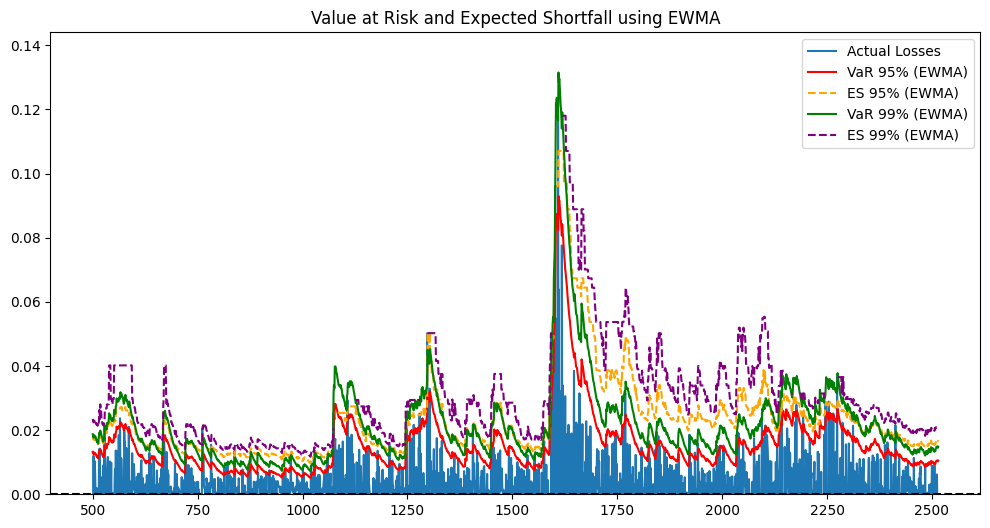

In [44]:
# Plotting the VaR estimates and the actual losses
plt.figure(figsize=(12,6))
plt.plot(dfB.index[window_size:], dfB['loss'].iloc[window_size:], label='Actual Losses')
plt.plot(dfB.index[window_size:], var_ewma, label='VaR 95% (EWMA)', color='red')
plt.plot(dfB.index[window_size:], ef_ewma_95, label='ES 95% (EWMA)', color='orange', linestyle='--')
plt.plot(dfB.index[window_size:], var_ewma_99, label='VaR 99% (EWMA)', color='green')
plt.plot(dfB.index[window_size:], ef_ewma_99, label='ES 99% (EWMA)', color='purple', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.title('Value at Risk and Expected Shortfall using EWMA')
plt.ylim(0)
plt.legend()
plt.show()

# GARCH